In [1]:
import enviroment
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

pygame 2.6.0 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#Funzioni necessarie per TabQFunction
def state_to_index(state_vector):
    pericoli = state_vector[0] * 4 + state_vector[1] * 2 + state_vector[2]
    direzione_corrente = state_vector[3] * 3 + state_vector[4] * 2 + state_vector[5] * 1
    posizione_frutto = np.mod(state_vector[7] * 6 + state_vector[8] * 3 + state_vector[9] * 2 + state_vector[10], 8)
    return pericoli * 32 + direzione_corrente * 8 + posizione_frutto
def initialize_QTable():
    return np.zeros((256, 3))

In [3]:
def tab_function(file_path, N_GAMES, visual=False, speed=0):
    Q_table = np.load(file_path)
    env_visual = enviroment.LinearStateSnakeGame(visual=visual, speed=speed)
    score_result = []
    for _ in range(N_GAMES):
        state = env_visual.reset()
        game_over = False
        while not game_over:
            state = env_visual.get_state()
            row_Q_value = state_to_index(state)
            action = np.argmax(Q_table[row_Q_value])
            final_move = [0, 0, 0]
            final_move[action] = 1
            _, _, game_over, score = env_visual.play_step(final_move)
        score_result.append(score)  
    return score_result

def dqn_easy_state(file_path, N_GAMES, visual=False, speed=0):
    model = keras.models.load_model(file_path)
    env_visual = enviroment.LinearStateSnakeGame(visual=visual, speed=speed)
    score_result = []
    for _ in range(N_GAMES):
        state = env_visual.reset()
        state = env_visual.get_state()
        game_over = False
        while not game_over:
            action = np.argmax(model(state[np.newaxis])[0])
            final_move = [0, 0, 0]
            final_move[action] = 1
            state, _, game_over, score = env_visual.play_step(final_move)
        score_result.append(score)  
    return score_result

def dqn_matrix_state(file_path, N_GAMES, visual=False, speed=0, visual_range=7):
    model = keras.models.load_model(file_path)
    env_visual = enviroment.MatrixStateSnakeGame(visual=visual, speed=speed, visual_range=visual_range)
    score_result = []
    for _ in range(N_GAMES):
        state = env_visual.reset()
        state = env_visual.get_state()
        game_over = False
        while not game_over:
            action = np.argmax(model(state[np.newaxis])[0])
            final_move = [0,0,0,0]
            final_move[action] = 1
            state, _, game_over, score = env_visual.play_step(final_move)
        score_result.append(score)
    return score_result

Confronto tra differenti approcci ciascuno testato su 50 partite

In [4]:
score_result_t = tab_function(file_path="./Q_table/ExplorationFunction/890000step.npy",
             N_GAMES=50)
media_t = np.mean(score_result_t)
deviazione_std_t = np.std(score_result_t)
valore_max_t = np.max(score_result_t)
print(f"Media: {media_t}")
print(f"Deviazione standard: {deviazione_std_t}")
print(f"Valore massimo: {valore_max_t}")

Media: 31.74
Deviazione standard: 10.586425270127778
Valore massimo: 57


In [5]:
score_result_e = dqn_easy_state(file_path="./DQN_saved_model/easy_state/model_DDQN.keras",
             N_GAMES=50)
media_e = np.mean(score_result_e)
deviazione_std_e = np.std(score_result_e)
valore_max_e = np.max(score_result_e)
print(f"Media: {media_e}")
print(f"Deviazione standard: {deviazione_std_e}")
print(f"Valore massimo: {valore_max_e}")

Media: 28.86
Deviazione standard: 8.345082384254813
Valore massimo: 45


In [24]:
score_result_m7 = dqn_matrix_state(file_path="./DQN_saved_model/matrix_state/bmodel_DDQN.keras",
             N_GAMES=50, visual=False, speed=10, visual_range=7)
media_m7 = np.mean(score_result_m7)
deviazione_std_m7 = np.std(score_result_m7)
valore_max_m7 = np.max(score_result_m7)
print(f"Media: {media_m7}")
print(f"Deviazione standard: {deviazione_std_m7}")
print(f"Valore massimo: {valore_max_m7}")

Media: 42
Deviazione standard: 10.118912985098746
Valore massimo: 65


In [23]:
score_result_m9 = dqn_matrix_state(file_path="./DQN_saved_model/matrix_state/model_9_3h_DDQN.keras",
             N_GAMES=50, visual=False, speed=10, visual_range=9)
media_m9 = np.mean(score_result_m9)
deviazione_std_m9 = np.std(score_result_m9)
valore_max_m9 = np.max(score_result_m9)
print(f"Media: {media_m9}")
print(f"Deviazione standard: {deviazione_std_m9}")
print(f"Valore massimo: {valore_max_m9}")

Media: 49.45
Deviazione standard: 10.262085558014025
Valore massimo: 70


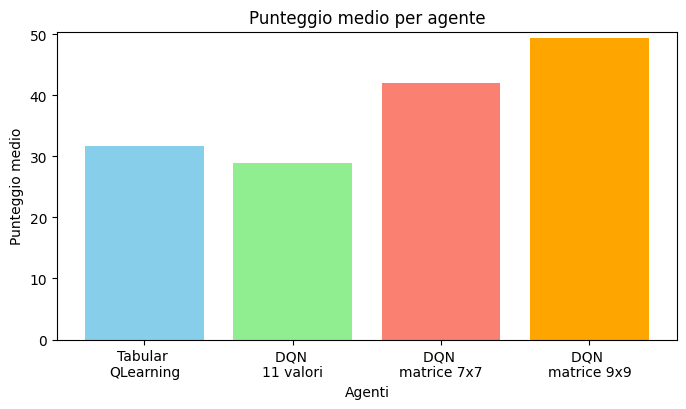

In [26]:
medie = [media_t, media_e, media_m7, media_m9]
labels = ["Tabular \nQLearning", "DQN \n11 valori", "DQN \nmatrice 7x7", "DQN \nmatrice 9x9"]  
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

plt.figure(figsize=(8, 4))
plt.bar(labels, medie, color=colors)
plt.xlabel('Agenti')
plt.ylabel('Punteggio medio')
plt.title('Punteggio medio per agente')
plt.ylim(0, max(medie) + 1)
plt.show()

# Test per verificare che il modello si accorga di morte imminente in caso di prosecuzione verso il frutto

In [3]:
def tab_test_one(file_path, speed=5):
    Q_table = np.load(file_path)
    env = enviroment.LinearStateSnakeGame(visual=True, speed=speed)
    state = env.reset()
    env.set_test_uno()
    state = env.get_state()
    game_over = False
    step_after_score=0
    while not game_over:
        state = env.get_state()
        row_Q_value = state_to_index(state)
        action = np.argmax(Q_table[row_Q_value])
        final_move = [0,0,0]
        final_move[action] = 1
        state, _, game_over, score = env.play_step(final_move)
        if score==1:
            if step_after_score>=10:
                print("Test succeded!")
                env.close_pygame()
                return
            else:
                step_after_score+=1
    print("Test failed!")       
    env.close_pygame()
    
def dqn_easy_test_one(file_path, speed=5):
    model = keras.models.load_model(file_path)
    env = enviroment.LinearStateSnakeGame(visual=True, speed=speed)
    state = env.reset()
    env.set_test_uno()
    state = env.get_state()
    game_over = False
    step_after_score=0
    while not game_over:
        action = np.argmax(model(state[np.newaxis])[0])
        final_move = [0,0,0]
        final_move[action] = 1
        state, _, game_over, score = env.play_step(final_move)
        if score==1:
            if step_after_score>=10:
                print("Test succeded!")
                env.close_pygame()
                return
            else:
                step_after_score+=1
    print("Test failed!")       
    env.close_pygame()

def dqn_matrix_test_one(file_path, speed=5):
    model = keras.models.load_model(file_path)
    env = enviroment.MatrixStateSnakeGame(visual=True, speed=speed)
    state = env.reset()
    env.set_test_uno()
    state = env.get_state()
    env.update_ui()
    game_over = False
    step_after_score=0
    while not game_over:
        action = np.argmax(model(state[np.newaxis])[0])
        final_move = [0,0,0,0]
        final_move[action] = 1
        state, _, game_over, score = env.play_step(final_move)
        if score>=1:
            if step_after_score>=10:
                print("Test succeded!")
                env.close_pygame()
                return
            else:
                step_after_score+=1
    print("Test failed!")       
    env.close_pygame()

In [23]:
tab_test_one("./Q_table/ExplorationFunction/890000step.npy", speed=5)

Test failed!


In [5]:
dqn_easy_test_one("./DQN_saved_model/easy_state/model_DDQN.keras", speed=5)

Test failed!


In [4]:
dqn_matrix_test_one("./DQN_saved_model/matrix_state/model_DDQN.keras", speed=5)

Test succeded!
